# Machine learning tests are run here
This notebook shows several experiments on the (raw) palsy dataset, using different types of machine learning algorithms.

The first code blocks always have to be run, the reset (all experiments) can be run individually when interested in a certain algorithm type.

## Imports and definitions
Mandatory section.

We start with importing some necessary packages and defning the function(s) used.

In [1]:
import numpy as np
import matplotlib as plt

def print_confusion_matrix(matrix):
    print("    p  c  h")
    print('p',matrix[0])
    print('c',matrix[1])
    print('h',matrix[2])

## Make the dataset
Mandatory section.

Here, we make the dataset that we will use.

In [3]:
# dataset settings:
full_data = True
full_features = False

# load the features
dftrain = np.load('features.npy')
# load the corresponding labels
y_train = np.load('labels.npy')

# (potentially) discard some data
if not full_data: 
    # leave out the first 50 peripheral patients for a more balanced dataset
    dftrain = dftrain[50:,:]
    y_train = y_train[50:]
if not full_features: 
    # leave out the chin landmarks for more significant data
    dftrain = dftrain[:,34:]

# scale the data so every 'coordinate' is between 0 and 1,
# this works because the coordinates are on a 900x900 grid.
dftrain = dftrain / 900.0

# define class names for use in printing predictions
classes = ['peripheral palsy', 'central palsy', 'healthy']
count_classes = np.bincount(y_train)

# print the size of the dataset
print("Features shape:",dftrain.shape,'.',"Labels shape:",y_train.shape,'.')
# print("Labels shape:",y_train.shape)
print('\t',"Of which:")
print('\t',count_classes[0],classes[0])
print('\t',count_classes[1],classes[1])
print('\t',count_classes[2],classes[2])


Features shape: (203, 102) . Labels shape: (203,) .
	 Of which:
	 103 peripheral palsy
	 40 central palsy
	 60 healthy


## Model 1
Optional section.

This is the first experiment. 
A DNN is made with many different amounts of hidden layers and nodes. 
The final accuracy is printed using LOOCV.

In [10]:
# source: adapted from https://www.freecodecamp.org/learn/machine-learning-with-python/

# results: not working well. probably not enough datapoints available.

# imports:
import tensorflow as tf

# use leave-one-out cross-validation to test the accuracy of the model
correct = 0
n = len(y_train)
for i in range(len(y_train)):
    # print("Run", i+1, "of", len(dftrain))
    x_test = dftrain[i]
    x_test = np.reshape(x_test, (1,-1))
    y_test = y_train[i]
    x_train_loocv = np.delete(dftrain, i, 0)
    y_train_loocv = np.delete(y_train, i, 0)
    model1 = tf.keras.Sequential([
        # tf.keras.layers.Dense(136, activation='relu'),
        tf.keras.layers.Dense(108800, activation='relu'),
        # tf.keras.layers.Dense(10880, activation='relu'),
        tf.keras.layers.Dense(3, activation='sigmoid'),
    ])

    model1.compile(
        optimizer = tf.keras.optimizers.Adam(),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics = tf.keras.metrics.CategoricalAccuracy(),
    )
    model1.fit(x_train_loocv, y_train_loocv, epochs=1, verbose=0, batch_size=len(x_train_loocv), shuffle=True)
    prediction = np.argmax(model1.predict(x_test))
    # print("Prediction:", classes[prediction.astype(int)])
    # print("Actual:    ", classes[y_test.astype(int)])
    if (prediction == y_test):
        correct += 1
print("Final accuracy =", correct/n)

Final accuracy = 0.3092105263157895


## Model 2
Optional section.

This is the second experiment. A support vector machine (SVM) will be built.

In [19]:
# source: adapted from https://scikit-learn.org/stable/modules/svm.html#svm-classification

# results: (using kernel='poly', degree=5, weights={0:1.,1:1.,2:1.})
    # full data, full features: .823
    # full data, part features: .847
    # part data, full features: .842
    # part data, part features: .829

# imports:
from sklearn import svm

# model settings:
kernel = 'poly'
degree = 10
weights = 'balanced'#{0:0.5, 1:2.0, 2:1.0}

# use leave-one-out cross-validation to test the accuracy of the model
correct = 0
confusion_matrix = [[0,0,0], [0,0,0], [0,0,0]]
n = len(y_train)
for i in range(len(y_train)):
    x_test = dftrain[i]
    x_test = np.reshape(x_test, ([1,-1]))
    y_test = y_train[i]
    x_train_loocv = np.delete(dftrain, i, 0)
    y_train_loocv = np.delete(y_train, i, 0)
    model2 = svm.SVC(kernel=kernel,degree=degree,class_weight=weights)
    model2.fit(x_train_loocv, y_train_loocv)
    prediction = model2.predict(x_test)
    if (prediction == y_test):
        correct += 1
    confusion_matrix[prediction[0]][y_test] += 1
print("Final accuracy =", correct/n)
print_confusion_matrix(confusion_matrix)

Final accuracy = 0.8226600985221675
    p  c  h
p [83, 15, 1]
c [19, 25, 0]
h [1, 0, 59]


## Model 3
Optional section.

This is the third experiment. 
This model uses a K-nearest neighbors (KNN) algorithm to classify the data.

In [54]:
# source: adated from https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

# results: (using n_neighbors=5, weight='distance')
    # full data, full features: .700
    # full data, part features: .754
    # part data, full features: .632
    # part data, part features: .678

# imports:
from sklearn import neighbors

# model settings:
n_neighbors = 5
weight = 'distance'

# use leave-one-out cross-validation to test the accuracy of the model
correct = 0
confusion_matrix = [[0,0,0], [0,0,0], [0,0,0]]
n = len(y_train)
for i in range(len(y_train)):
    x_test = dftrain[i]
    x_test = np.reshape(x_test, ([1,-1]))
    y_test = y_train[i]
    x_train_loocv = np.delete(dftrain, i, 0)
    y_train_loocv = np.delete(y_train, i, 0)
    model3 = neighbors.KNeighborsClassifier(n_neighbors, weights=weight)
    model3.fit(x_train_loocv, y_train_loocv)
    prediction = model3.predict(x_test)
    if (prediction == y_test):
        correct += 1
    confusion_matrix[prediction[0]][y_test] += 1
print("Final accuracy =", correct/n)
print_confusion_matrix(confusion_matrix)

Final accuracy = 0.7536945812807881
------------------
     Actual
   p   c   h
p [86, 17, 2]
c [9, 11, 2]
h [8, 12, 56]


## Model 4
Optional section.

This is the fourth experiment. 
A Random Forest classification system is used.

In [4]:
# source: adapted from https://scikit-learn.org/stable/modules/ensemble.html#forest

# results: (using n_estimators=136)
    # full data, full features: .773
    # full data, part features: .783
    # part data, full features: .763
    # part data, part features: .743

# imports:
from sklearn import ensemble

# model settings:
n_estimators_total = 700
accuracy = np.load('accuracy_randomforest.npy')
accuracy = accuracy.tolist()
for n_estimators in range(len(accuracy)+1, n_estimators_total):
    # use leave-one-out cross-validation to test the accuracy of the model
    print("Run",n_estimators,"of",n_estimators_total,':')
    correct = 0
    # confusion_matrix = [[0,0,0], [0,0,0], [0,0,0]]
    n = len(y_train)
    for i in range(len(y_train)):
        x_test = dftrain[i]
        x_test = np.reshape(x_test, ([1,-1]))
        y_test = y_train[i]
        x_train_loocv = np.delete(dftrain, i, 0)
        y_train_loocv = np.delete(y_train, i, 0)
        model4 = ensemble.RandomForestClassifier(n_estimators)
        model4.fit(x_train_loocv, y_train_loocv)
        prediction = model4.predict(x_test)
        if (prediction == y_test):
            correct += 1
        # confusion_matrix[prediction[0]][y_test] += 1
    print("accuracy:",correct/n)
    accuracy.append(correct/n)
    np.save("accuracy_randomforest.npy", accuracy)
    # print("Final accuracy =", correct/n)
    # print_confusion_matrix(confusion_matrix)

Run 452 of 1020 :
accuracy: 0.7635467980295566
Run 453 of 1020 :
accuracy: 0.7783251231527094
Run 454 of 1020 :
accuracy: 0.7832512315270936
Run 455 of 1020 :
accuracy: 0.7684729064039408
Run 456 of 1020 :
accuracy: 0.7832512315270936
Run 457 of 1020 :
accuracy: 0.7733990147783252
Run 458 of 1020 :
accuracy: 0.7832512315270936
Run 459 of 1020 :
accuracy: 0.7733990147783252
Run 460 of 1020 :
accuracy: 0.7783251231527094
Run 461 of 1020 :
accuracy: 0.7783251231527094
Run 462 of 1020 :
accuracy: 0.7684729064039408
Run 463 of 1020 :
accuracy: 0.7635467980295566
Run 464 of 1020 :
accuracy: 0.7684729064039408
Run 465 of 1020 :
accuracy: 0.7733990147783252
Run 466 of 1020 :
accuracy: 0.7684729064039408
Run 467 of 1020 :
accuracy: 0.7684729064039408
Run 468 of 1020 :
accuracy: 0.7733990147783252
Run 469 of 1020 :
accuracy: 0.7733990147783252
Run 470 of 1020 :
accuracy: 0.7733990147783252
Run 471 of 1020 :
accuracy: 0.7733990147783252
Run 472 of 1020 :
accuracy: 0.7684729064039408
Run 473 of 10

Text(0, 0.5, 'Testing Accuracy')

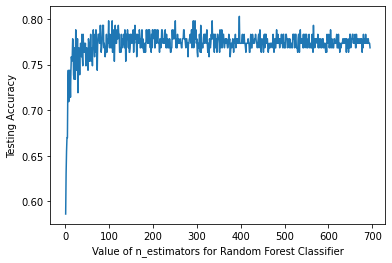

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = np.load("accuracy_randomforest.npy")
plt.plot(range(1,len(accuracy)+1), accuracy)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Testing Accuracy')

## Model 5
Optional section.

This is the fifth experiment. 
A Gaussian Naive Bayes model is built here.

In [19]:
# source: adapted from https://scikit-learn.org/stable/modules/naive_bayes.html

# results: (no specific settings for this model)
    # full data, full features: .601
    # full data, part features: .610
    # part data, full features: .572
    # part data, part features: .579

# imports:
from sklearn import naive_bayes

# model settings:

# use leave-one-out cross-validation to test the accuracy of the model
correct = 0
confusion_matrix = [[0,0,0], [0,0,0], [0,0,0]]
n = len(y_train)
for i in range(len(y_train)):
    x_test = dftrain[i]
    x_test = np.reshape(x_test, ([1,-1]))
    y_test = y_train[i]
    x_train_loocv = np.delete(dftrain, i, 0)
    y_train_loocv = np.delete(y_train, i, 0)
    model5 = naive_bayes.GaussianNB()
    model5.fit(x_train_loocv, y_train_loocv)
    prediction = model5.predict(x_test)
    if (prediction == y_test):
        correct += 1
    confusion_matrix[prediction[0]][y_test] += 1
print("Final accuracy =", correct/n)
print_confusion_matrix(confusion_matrix)

Final accuracy = 0.5789473684210527


## Model 6
Optional section.

This is the sixth experiment. 
A decision tree is used in the following code block.

In [20]:
# source: adapted from https://scikit-learn.org/stable/modules/tree.html#classification

# results: (using depth=10)
    # full data, full features: .700
    # full data, part features: .695
    # part data, full features: .664
    # part data, part features: .638

# imports:
from sklearn import tree

# model settings:
depth = 10

# use leave-one-out cross-validation to test the accuracy of the model
correct = 0
confusion_matrix = [[0,0,0], [0,0,0], [0,0,0]]
n = len(y_train)
for i in range(len(y_train)):
    x_test = dftrain[i]
    x_test = np.reshape(x_test, ([1,-1]))
    y_test = y_train[i]
    x_train_loocv = np.delete(dftrain, i, 0)
    y_train_loocv = np.delete(y_train, i, 0)
    model6 = tree.DecisionTreeClassifier(max_depth=depth)
    model6.fit(x_train_loocv, y_train_loocv)
    prediction = model6.predict(x_test)
    if (prediction == y_test):
        correct += 1
    confusion_matrix[prediction[0]][y_test] += 1
print("Final accuracy =", correct/n)
print_confusion_matrix(confusion_matrix)

Final accuracy = 0.6381578947368421


## Model 7
Optional section.

This is the seventh experiment. 
A DNN is implemented here, this time using sklearn instead of tensorflow.

In [69]:
# source: adapted from https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

# results: not working well yet, lots of errors

# imports:
from sklearn import neural_network

# model settings:
solver = 'adam'
alpha = 1e-5
hidden_layers = (5)
random = 1

# use leave-one-out cross-validation to test the accuracy of the model
correct = 0
n = len(y_train)
for i in range(len(y_train)):
    x_test = dftrain[i]
    x_test = np.reshape(x_test, ([1,-1]))
    y_test = y_train[i]
    x_train_loocv = np.delete(dftrain, i, 0)
    y_train_loocv = np.delete(y_train, i, 0)
    model7 = neural_network.MLPClassifier(solver=solver, alpha=alpha, hidden_layer_sizes=hidden_layers, random_state=random)
    model7.fit(x_train_loocv, y_train_loocv)
    prediction = model7.predict(x_test)
    if (prediction == y_test):
        correct += 1
print("Final accuracy =", correct/n)

/home/cvvletter/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cvvletter/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cvvletter/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cvvletter/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cvvletter/.local/lib/python3.8/sit

Final accuracy = 0.3881578947368421


/home/cvvletter/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
